In [45]:
import tensorflow as tf

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
data = pd.read_csv('C:/Users/harib/Desktop/Stress/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [48]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


In [49]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#data_train = data_train[data_train['emotion']!=1]
#data_val = data_val[data_val['emotion']!=1]
##data_test = data_test[data_test['emotion']!=1]
#data_train['emotion'] = data_train['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_test['emotion'] = data_test['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_val['emotion'] = data_val['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


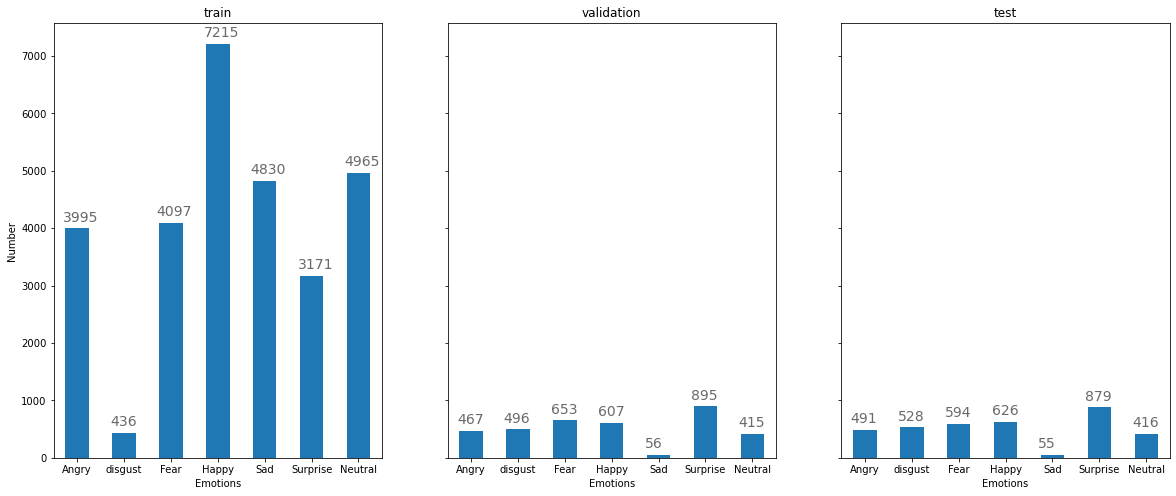

In [50]:
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [51]:
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [52]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [53]:
import os
import cv2

data_path = 'C:/Users/harib/Desktop/Stress/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

numbers = []
c=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        input_img_resize = np.reshape(input_img_resize,(48,48,1))
        img_data_list.append(input_img_resize)
        c += 1
    numbers.append(c)
    c = 0
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(981, 48, 48, 1)

In [54]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=6 #54
labels[189:365]=1 #177
labels[366:440]=2 #75
labels[441:647]=3 #207
labels[648:731]=4 #84
labels[732:980]=5 #249

names = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def getLabel(id):
    return ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]

In [55]:
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)

In [56]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(48, 48, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2,3, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, t)

    return model

In [57]:
pip install stn

Note: you may need to restart the kernel to use updated packages.


In [58]:
from tensorflow import keras
from keras import layers
from stn import spatial_transformer_network as transformer

img_inputs = keras.Input(shape=(48,48,1))

locnet = layers.Conv2D(32,3, padding='same')(img_inputs)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(64,3, padding='same')(locnet)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(96,3, padding='same')(locnet)
feat_map = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Flatten()(feat_map)
locnet = layers.Dense(90, activation='relu',kernel_regularizer='l2')(locnet)
locnet = layers.Dropout(0.2)(locnet)
locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
theta = layers.Dense(6, activation='linear')(locnet)

locnet = keras.Model(img_inputs, theta, name="locnet")
#locnet.summary()

#spatial transformer network
outstn = transformer(feat_map,theta)



#feature extraction network
fe = layers.Conv2D(32,3, padding='same')(img_inputs)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(64,3, padding='same')(fe)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(96,3, padding='same')(fe)
fe = layers.Activation('relu')(fe)
do = layers.BatchNormalization()(fe)

fe = keras.Model(img_inputs, do, name="feature extractor")
#fe.summary()

add = layers.Add()([outstn, do])

flats = layers.Flatten()(add)
flats = layers.Dense(64, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
flats = layers.Dense(32, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
#output = layers.Dense(6, activation='softmax')(flats)

x1 = layers.Dense(7, activation='linear')(flats)
x2 = layers.Dense(7,activation='linear')(flats)
x3 = layers.Dense(7,activation='linear')(flats)
x4 = layers.Dense(7,activation='linear')(flats)
avg = layers.Average()([x1, x2, x3, x4])
out = layers.Dense(7, activation='softmax')(avg)

model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=lr_schedule), 
              metrics=['accuracy'])

model.summary()

Model: "FEMSTN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_81 (Conv2D)             (None, 48, 48, 32)   320         ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 16, 16, 32)  0           ['conv2d_81[0][0]']              
 )                                                                                                
                                                                                                  
 activation_15 (Activation)     (None, 16, 16, 32)   0           ['max_pooling2d_17[0][0]']  

In [59]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [60]:
from keras.layers import LeakyReLU

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(48, 48, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 2
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))


#dense 4
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100,
    decay_rate=0.5,
    staircase=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(0.01), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 46, 46, 256)       2560      
                                                                 
 batch_normalization_90 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 46, 46, 256)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 46, 46, 256)       590080    
                                                                 
 batch_normalization_91 (Bat  (None, 46, 46, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 46, 46, 256)      

In [61]:
batch_size = 128
epochs = 1

In [37]:
import statistics

In [ ]:

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True
)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

cp_path = './model_bacc.h5'
cpl_path = './model_fer_bloss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,save_best_only=True, save_weights_only=False, verbose=0, monitor='val_accuracy')
cpl = tf.keras.callbacks.ModelCheckpoint(filepath=cpl_path,save_best_only=True, save_weights_only=False, verbose=2, monitor='val_loss')
history = model.fit(data_generator.flow(train_X, train_Y, 256),
                                epochs=1,
                                verbose=1, 
                                callbacks = [cp, cpl, es],
                                validation_data=(val_X, val_Y))


In [18]:

from keras.models import load_model
me=load_model("_mini_XCEPTION.102-0.66(1).hdf5")

In [6]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


from sklearn.model_selection import train_test_split

# parameters
batch_size = 32
num_epochs = 10000
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'models/'

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# model parameters/compilation
model = me(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()





    # callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

# loading dataset
faces, emotions =pd.read_csv('C:/Users/harib/Desktop/Stress/fer2013.csv')
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)
model.fit_generator(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

ValueError: Layer "model_1" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=48>, <tf.Tensor: shape=(), dtype=int32, numpy=48>, <tf.Tensor: shape=(), dtype=int32, numpy=1>]

In [19]:
me.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
me.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 62, 62, 8)    72          ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 62, 62, 8)   32          ['conv2d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_1 (Activation)      (None, 62, 62, 8)    0           ['batch_normalization_1[0][

In [20]:
me.save_weights("miniweight.h5")

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions

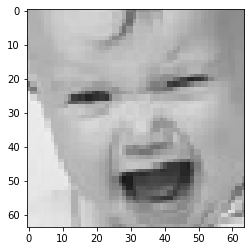

In [16]:
IMAGE_PATH='./test.jpg'
img=tf.keras.preprocessing.image.load_img(IMAGE_PATH,target_size=(64,64,1))
img=tf.keras.preprocessing.image.img_to_array(img)#view the image
plt.imshow(img/255.)

In [17]:
import requests#fetching labels from Imagenet  
response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
imgnet_map=response.json()
imgnet_map={v[1]:k for k, v in imgnet_map.items()}#make model predictionsimg=tf.keras.applications.xception.preprocess_input(img)
predictions=me.predict(np.array([img]))
decode_predictions(predictions,top=5)

ValueError: in user code:

    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\harib\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 248, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "model_1" (type Functional).
    
    Input 0 of layer "conv2d_1" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)
      • training=False
      • mask=None
